In [1]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395662 sha256=45af7a31e4a0c10a7b1c3dc19dd1df6f1c1f3f809b13d101419b662f6ab5580d
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [2]:
import pandas as pd
# "The cleaning supply"
import re
import string
# "NLP Supply"
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
train = pd.read_csv('sample_data/Train.csv')
test = pd.read_csv('sample_data/Test.csv')

In [4]:
train.head()


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
test.head()


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [6]:
# Initialize the lemmarizer and stemmer
wordnet_lemmatizer = WordNetLemmatizer()
englishStemmer=SnowballStemmer("english")

def clean_text(x):
    # Remove zero width space from the string and lower it
    temp_text = x.lower().replace('\u200b', '')
    # Remove punctuation of the string
    temp_text = temp_text.translate(str.maketrans('', '', string.punctuation))
    # Remove new line from string
    temp_text = temp_text.replace('\n', '')
    # Remove double space or more
    temp_text = re.sub(' +', ' ', temp_text).strip()
    # Tokenized the text
    temp_text = nltk.word_tokenize(temp_text)
    stop_words = set(stopwords.words('english'))
    
    filtered_word = []
    
    for word in temp_text:
        # Lemmanize and stem word
        lemma_word = wordnet_lemmatizer.lemmatize(word)
        stemmed_word = englishStemmer.stem(lemma_word)
        
        # Do not add stop words into the the final cleaned sentence
        if stemmed_word in stop_words:
            continue
        else:
            filtered_word.append(stemmed_word)
            
    return " ".join(filtered_word).strip()

In [7]:
# Clean all of the review in training, and test
train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

In [8]:
VAL_PERCENTAGE = 0.2
N_VAL = int(len(train) * VAL_PERCENTAGE)

# Shuffle train DataFrame also reset the shuffled index
train = train.sample(frac=1).reset_index(drop=True)

# Set validation DataFrame as having the first N_VAL row
val_data = train[:N_VAL]

# Set train DataFrame as the rest
train_data = train[N_VAL:]

In [9]:
val_data.describe()


,label
count,8000.000000
mean,0.505375
std,0.500002
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
train_data.describe()


,label
count,32000.000000
mean,0.498063
std,0.500004
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
validation_file_path = "./review.val"
training_file_path = "./review.train"

def append_fasttext_dataset(row, file_writer):
    def convert_row_to_dataset_string(row):
        return "__label__" + str(row['label']) + " " + row['text']
    
    file_writer.write(convert_row_to_dataset_string(row) + '\n')

In [12]:
# Validation file
with open(validation_file_path, 'a+') as writer:
    val_data.apply(lambda x: append_fasttext_dataset(x, writer), axis=1)
    
# Training file
with open(training_file_path, 'a+') as writer:
    train_data.apply(lambda x: append_fasttext_dataset(x, writer), axis=1)

<Axes: >

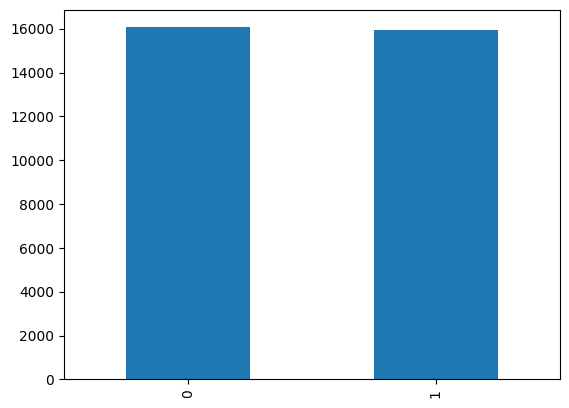

In [15]:
# Look at number of label (0,1) of the training data
train_data['label'].value_counts().plot.bar()

<Axes: >

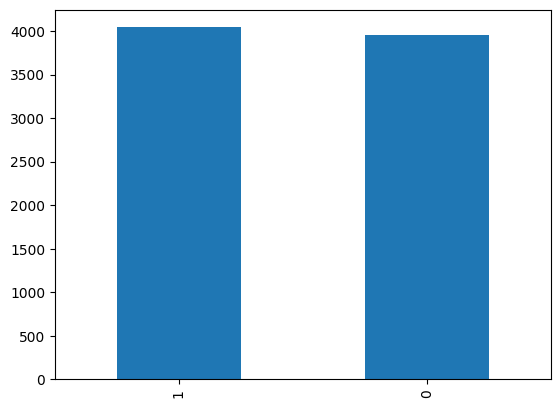

In [16]:
# Look at number of label (0,1) of the validation data
val_data['label'].value_counts().plot.bar()

In [17]:
import fasttext


In [18]:
hyper_params = {
    "lr": 0.01,
    "epoch": 15,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1
}

In [19]:
model = fasttext.train_supervised(input=training_file_path, **hyper_params)

In [20]:
import matplotlib.pyplot as plt


Result :  (32000, 0.81696875, 0.81696875)
Validation :  (8000, 0.802875, 0.802875)


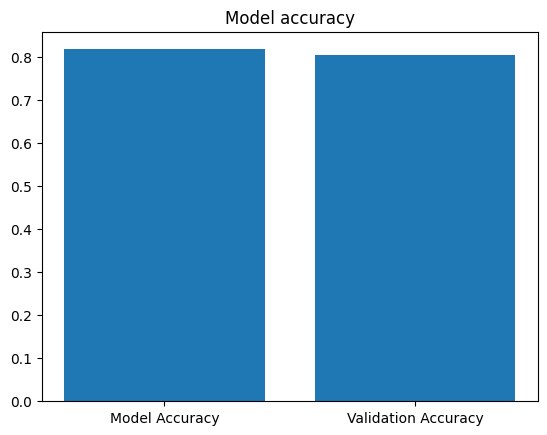

In [21]:
# Get model accuracy and accuracy of the validation
result = model.test(training_file_path)
validation = model.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy")
plt.bar(labels, accuracy_data)
plt.show()

In [22]:
def get_predicted_rating(x, model):
    return int(model.predict(x)[0][0].split('__label__')[1])

In [23]:
print(val_data)

                                                   text  label
0     birth beatl u televis movi releas fall 1979 ha...      1
1     see quit posit review board tri reviv film lac...      0
2     watch bond film 1983 isnt good octopussi still...      1
3     vote excel well act wa content still give chil...      1
4     relentless like one loud action movi entir cas...      0
...                                                 ...    ...
7995  terribl terribl movi televis onc lifetim bring...      0
7996  film wa unfocus rambl uneven wa effort watch w...      0
7997  couldnt even sit whole thing movi wa piec crap...      0
7998  like movi anoth yash raj film know look good s...      1
7999  shes man wa everyth want mayb even littl love ...      1

[8000 rows x 2 columns]


In [24]:
val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model))

<ipython-input-24-22632eb393a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model))


In [25]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [26]:
confusion_labels = [0,1]
confusion_matrix_data = confusion_matrix(val_data["label"], val_data["predicted"], labels=confusion_labels)
normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

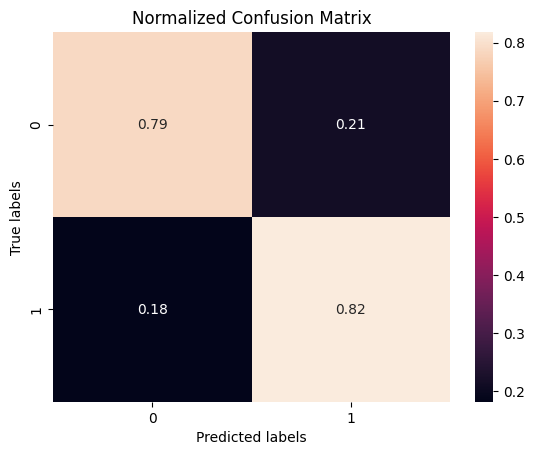

In [27]:
# Plot the normalised confusion matrix
ax = plt.subplot()
sns.heatmap(normalised_confusion_matrix, annot=True, ax=ax, fmt='.2f');

ax.set_title('Normalized Confusion Matrix')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(confusion_labels)
ax.yaxis.set_ticklabels(confusion_labels)

In [28]:
hyper_params_25_epoch = {
    "lr": 0.01,
    "epoch": 25,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1
}

In [29]:
model_25_epoch = fasttext.train_supervised(input=training_file_path, **hyper_params_25_epoch)

Result :  (32000, 0.87721875, 0.87721875)
Validation :  (8000, 0.862, 0.862)


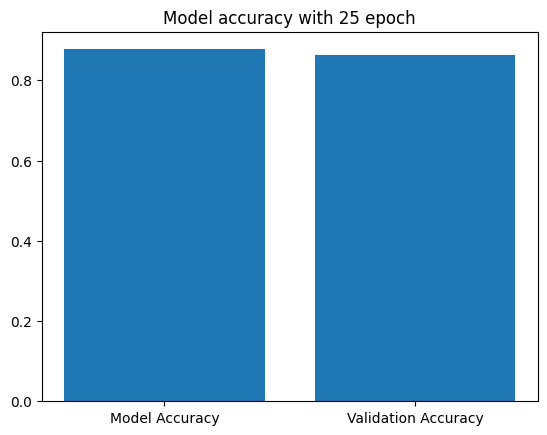

In [30]:
# Get model accuracy and accuracy of the validation
result = model_25_epoch.test(training_file_path)
validation = model_25_epoch.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy with 25 epoch")
plt.bar(labels, accuracy_data)
plt.show()

In [31]:
hyper_params_bigger_lr = {
    "lr": 0.6,
    "epoch": 15,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1
}

In [32]:
model_bigger_lr = fasttext.train_supervised(input=training_file_path, **hyper_params_bigger_lr)

Result :  (32000, 1.0, 1.0)
Validation :  (8000, 0.89975, 0.89975)


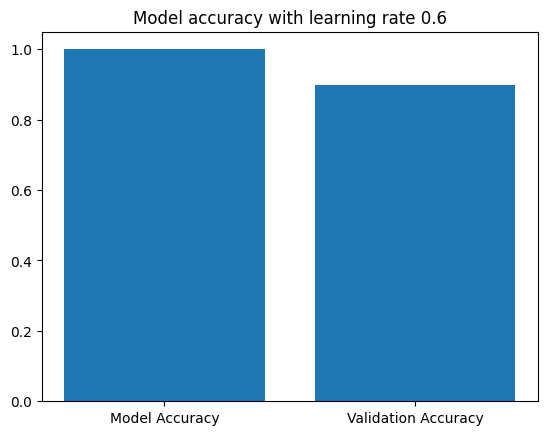

In [33]:
# Get model accuracy and accuracy of the validation
result = model_bigger_lr.test(training_file_path)
validation = model_bigger_lr.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy with learning rate 0.6")
plt.bar(labels, accuracy_data)
plt.show()

In [34]:
hyper_params_autotuning = {
    "lr": 0.06,
    "epoch": 20,
    "wordNgrams": 2,
    "dim": 20,
    "verbose": 1,
    "autotuneValidationFile": validation_file_path
}

In [35]:
model_autotuning = fasttext.train_supervised(input=training_file_path, **hyper_params_autotuning)

Result :  (32000, 0.9970625, 0.9970625)
Validation :  (8000, 0.89925, 0.89925)


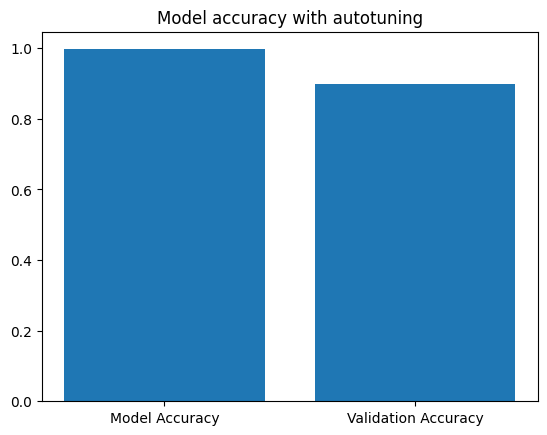

In [36]:
# Get model accuracy and accuracy of the validation
result = model_autotuning.test(training_file_path)
validation = model_autotuning.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy with autotuning")
plt.bar(labels, accuracy_data)
plt.show()

In [37]:
val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model_autotuning))

<ipython-input-37-ed17a307993a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model_autotuning))


In [38]:
confusion_labels = [0,1]
confusion_matrix_data = confusion_matrix(val_data["label"], val_data["predicted"], labels=confusion_labels)
normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

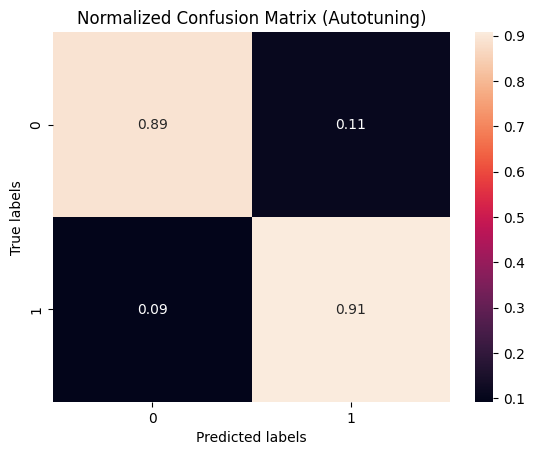

In [39]:
# Plot the normalised confusion matrix
ax = plt.subplot()
sns.heatmap(normalised_confusion_matrix, annot=True, ax=ax, fmt='.2f');

ax.set_title('Normalized Confusion Matrix (Autotuning)')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(confusion_labels)
ax.yaxis.set_ticklabels(confusion_labels)

In [40]:
hyper_params_autotuning_metrics = {
    "lr": 0.1,
    "epoch": 20,
    "wordNgrams": 2,
    "dim": 50,
    "verbose": 2,
    "autotuneValidationFile": validation_file_path,
    "autotuneMetric": "f1:__label__4"
}

In [ ]:
model_autotuning_metrics = fasttext.train_supervised(input=training_file_path, **hyper_params_autotuning_metrics)

In [1]:
# Get model accuracy and accuracy of the validation
result = model_autotuning_metrics.test(training_file_path)
validation = model_autotuning_metrics.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy with autotuning")
plt.bar(labels, accuracy_data)
plt.show()

NameError: ignored

In [ ]:
val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model_autotuning_metrics))

In [ ]:
confusion_labels = [0,1]
confusion_matrix_data = confusion_matrix(val_data["label"], val_data["predicted"], labels=confusion_labels)
normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]

In [ ]:
# Plot the normalised confusion matrix
ax = plt.subplot()
sns.heatmap(normalised_confusion_matrix, annot=True, ax=ax, fmt='.2f');

ax.set_title('Normalized Confusion Matrix (Autotuning Metrics f1:__label__4)')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(confusion_labels)
ax.yaxis.set_ticklabels(confusion_labels)

In [ ]:
hyper_params_autotuning_metrics_5 = {
    "lr": 0.1,
    "epoch": 20,
    "wordNgrams": 2,
    "dim": 50,
    "verbose": 2,
    "autotuneValidationFile": validation_file_path,
    "autotuneMetric": "f1:__label__5"
}

In [ ]:
model_autotuning_metrics_5 = fasttext.train_supervised(input=training_file_path, **hyper_params_autotuning_metrics_5)

In [ ]:
# Get model accuracy and accuracy of the validation
result = model_autotuning_metrics_5.test(training_file_path)
validation = model_autotuning_metrics_5.test(validation_file_path)

print("Result : ", result)
print("Validation : ", validation)

# Plot the result
accuracy_data = [result[1], validation[1]]
labels = ['Model Accuracy', 'Validation Accuracy']

plt.title("Model accuracy with autotuning metrics")
plt.bar(labels, accuracy_data)
plt.show()

In [ ]:
val_data['predicted'] = val_data['text'].apply(lambda x: get_predicted_rating(x, model_autotuning_metrics_5))

In [ ]:
confusion_labels = [0,1]
confusion_matrix_data = confusion_matrix(val_data["label"], val_data["predicted"], labels=confusion_labels)
normalised_confusion_matrix = confusion_matrix_data.astype('float') / confusion_matrix_data.sum(axis=1)[:, np.newaxis]

In [ ]:
# Plot the normalised confusion matrix
ax = plt.subplot()
sns.heatmap(normalised_confusion_matrix, annot=True, ax=ax, fmt='.2f');

ax.set_title('Normalized Confusion Matrix (Autotuning Metrics f1:__label__5)')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(confusion_labels)
ax.yaxis.set_ticklabels(confusion_labels)

In [ ]:
submission = test.copy()
submission['label'] = submission['text'].apply(lambda x: get_predicted_rating(x, model_autotuning_metrics))

del submission['text']

In [ ]:
submission.head()


In [ ]:
submission.to_csv('submission.csv', index=False)